In [5]:
!pip install inference_sdk
!pip install roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="218UpwuQTzvCcrDilyeC")
project = rf.workspace("titaniumsv5").project("chandrayaan-2-ohrc-lunar-crater-dataset")
version = project.version(4)
dataset = version.download("yolov9")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 5.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Chandrayaan-2-OHRC-Lunar-Crater-Dataset-4 in yolov9:: 100%|██████████| 127/127 [00:00<00:00, 5830.52it/s]


In [ ]:
import os
import cv2
import math
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="218UpwuQTzvCcrDilyeC"  # If you want to try yourself make a roboflow api key and replace that here
    # I have refreshed my api key so it won't work
)

def process_images(train_images_dir, valid_images_dir, output_folder="crator_images", model_id="lunar-crater-detection-2/2"):
    # This will take all the images from the dataset that we just downloaded and will run the crator detection model on it.
    # This will help in identification of all the major crators which will in turn help in the identification of the landing spot

    os.makedirs(output_folder, exist_ok=True)
    results_list = []
    output_image_paths = []

    def list_images(folder):
        valid_extensions = ('.png', '.jpg', '.jpeg')
        return sorted([
            os.path.join(folder, img) for img in os.listdir(folder)
            if img.lower().endswith(valid_extensions)
        ])

    train_images = list_images(train_images_dir)
    valid_images = list_images(valid_images_dir)
    all_images = train_images + valid_images

    for img_path in all_images:
        print(f"Processing {img_path}...")

        try:
            result = CLIENT.infer(img_path, model_id=model_id)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image {img_path}")
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for pred in result.get('predictions', []):
            x_center, y_center = pred['x'], pred['y']
            width, height = pred['width'], pred['height']
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)

            cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), color=(0, 0, 255), thickness=2)
            label = f"{pred['class']} {pred['confidence']:.2f}"
            cv2.putText(img_rgb, label, (x_min, max(y_min - 10, 0)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        base_name = os.path.basename(img_path)
        output_path = os.path.join(output_folder, base_name)
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, img_bgr)
        results_list.append(result)
        output_image_paths.append(output_path)

    df = pd.DataFrame({
        'image_path': output_image_paths,
        'inference_result': results_list
    })

    return df

In [ ]:
def create_occupancy_grid(image_path, predictions):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Cannot load image: {image_path}")
    H, W, _ = img.shape
    occupancy_grid = np.zeros((H, W), dtype=np.uint8)

    for pred in predictions:
        x_center = pred['x']
        y_center = pred['y']
        w = pred['width']
        h = pred['height']

        x_min = int(x_center - w / 2)
        x_max = int(x_center + w / 2)
        y_min = int(y_center - h / 2)
        y_max = int(y_center + h / 2)

        x_min = max(0, x_min)
        x_max = min(W - 1, x_max)
        y_min = max(0, y_min)
        y_max = min(H - 1, y_max)

        occupancy_grid[y_min:y_max+1, x_min:x_max+1] = 1

    return occupancy_grid

In [ ]:
def adjust_stop_to_max_sunlight(x, y, sunlight_map, window_radius=3):

    H, W = sunlight_map.shape
    x_min = max(0, x - window_radius)
    x_max = min(W - 1, x + window_radius)
    y_min = max(0, y - window_radius)
    y_max = min(H - 1, y + window_radius)

    best_val = sunlight_map[y, x]
    best_coord = (x, y)
    for yy in range(y_min, y_max+1):
        for xx in range(x_min, x_max+1):
            if sunlight_map[yy, xx] > best_val:
                best_val = sunlight_map[yy, xx]
                best_coord = (xx, yy)
    return best_coord

def plan_rover_path_avoid_craters_a_star(
    image_path,
    predictions,
    path_length_m=100,
    num_stops=10,
    real_width_m=600,
    real_height_m=150
):

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"[ERROR] Cannot load image: {image_path}")
        return None, None, None
    H, W, _ = img_bgr.shape
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    sunlight_map = gray.astype(np.float32) / 255.0

    occupancy_grid = create_occupancy_grid(image_path, predictions)

    scale_x = real_width_m / float(W)
    scale_y = real_height_m / float(H)

    start_x = int(0.1 * W)
    start_y = H // 2
    if occupancy_grid[start_y, start_x] == 1:
        found_free = False
        for offset in range(1, H // 2):
            for sign in [+1, -1]:
                test_y = start_y + sign * offset
                if 0 <= test_y < H and occupancy_grid[test_y, start_x] == 0:
                    start_y = test_y
                    found_free = True
                    break
            if found_free:
                break
        if not found_free:
            print("[ERROR] No free landing spot found near left edge.")
            return None, None, None

    def dist_m(px1, py1, px2, py2):
        dx = (px2 - px1) * scale_x
        dy = (py2 - py1) * scale_y
        return math.sqrt(dx*dx + dy*dy)

    g_map = np.full((H, W), np.inf, dtype=np.float32)
    g_map[start_y, start_x] = 0.0
    predecessor = np.full((H, W, 2), -1, dtype=np.int32)

    def heuristic(px, py):
        d = dist_m(start_x, start_y, px, py)
        return max(0.0, path_length_m - d)

    open_set = []
    start_h = heuristic(start_x, start_y)
    heapq.heappush(open_set, (start_h, start_x, start_y))

    neighbors_8 = [(-1, 0), (1, 0), (0, -1), (0, 1),
                   (-1, -1), (-1, 1), (1, -1), (1, 1)]

    sunlight_weight = 10.0
    max_expansions = W * H
    expansions_count = 0
    path_found = False
    goal_x, goal_y = None, None

    while open_set and expansions_count < max_expansions:
        expansions_count += 1
        f, cx, cy = heapq.heappop(open_set)
        if f > g_map[cy, cx] + heuristic(cx, cy):
            continue
        if dist_m(start_x, start_y, cx, cy) >= path_length_m:
            path_found = True
            goal_x, goal_y = cx, cy
            break

        for dx, dy in neighbors_8:
            nx, ny = cx + dx, cy + dy
            if 0 <= nx < W and 0 <= ny < H:
                if occupancy_grid[ny, nx] == 1:
                    continue

                step_distance = dist_m(cx, cy, nx, ny)
                s_intensity = sunlight_map[ny, nx]
                sunlight_penalty = sunlight_weight * (1 - s_intensity)
                new_g = g_map[cy, cx] + step_distance + sunlight_penalty

                if new_g < g_map[ny, nx]:
                    g_map[ny, nx] = new_g
                    predecessor[ny, nx] = [cy, cx]
                    new_f = new_g + heuristic(nx, ny)
                    heapq.heappush(open_set, (new_f, nx, ny))

    if not path_found:
        print("[INFO] No path of >= 100m found from the start. Try adjusting parameters.")
        return None, None, None

    path_coords = []
    py, px = goal_y, goal_x
    while True:
        path_coords.append((px, py))
        ppy, ppx = predecessor[py, px]
        if ppy == -1 or ppx == -1:
            break
        py, px = ppy, ppx
    path_coords.reverse()

    total_dist = 0.0
    stops = []
    if len(path_coords) > 1:
        interval = dist_m(start_x, start_y, goal_x, goal_y) / (num_stops + 1)
        dist_since_last_stop = 0.0
        prev_x, prev_y = path_coords[0]
        stops_collected = 0

        for i in range(1, len(path_coords)):
            cur_x, cur_y = path_coords[i]
            step_m = dist_m(prev_x, prev_y, cur_x, cur_y)
            dist_since_last_stop += step_m
            total_dist += step_m

            while dist_since_last_stop >= interval and stops_collected < num_stops:
                overshoot = dist_since_last_stop - interval
                frac = 1.0 - overshoot / step_m if step_m > 0 else 0
                candidate_x = int(prev_x + frac * (cur_x - prev_x))
                candidate_y = int(prev_y + frac * (cur_y - prev_y))
                stop_x, stop_y = adjust_stop_to_max_sunlight(candidate_x, candidate_y, sunlight_map, window_radius=3)
                stops.append((stop_x, stop_y))
                stops_collected += 1
                dist_since_last_stop -= interval
            prev_x, prev_y = cur_x, cur_y

    annotated_img = img_rgb.copy()
    for i in range(len(path_coords) - 1):
        x1, y1 = path_coords[i]
        x2, y2 = path_coords[i+1]
        cv2.line(annotated_img, (x1, y1), (x2, y2), (0, 255, 255), 2)

    sx, sy = path_coords[0]
    cv2.circle(annotated_img, (sx, sy), 6, (0, 255, 0), -1)
    ex, ey = path_coords[-1]
    cv2.circle(annotated_img, (ex, ey), 6, (255, 0, 0), -1)

    for (sx, sy) in stops:
        cv2.circle(annotated_img, (sx, sy), 3, (255, 0, 0), -1)

    return annotated_img, path_coords, stops

Processing /content/train/images/100_jpg.rf.efb4b46e3134cbceabf12a6d540b3cbd.jpg...
Processing /content/train/images/13_jpg.rf.5178f1551e33147e180781feccdae03d.jpg...
Processing /content/train/images/14_jpg.rf.eaf17bb886ffc80b08fed4d707d964a0.jpg...
Processing /content/train/images/17_jpg.rf.8651f0005258921c54c3a6b340997f0a.jpg...
Processing /content/train/images/18_jpg.rf.b1638a0575d9659ee7178296c94e0e30.jpg...
Processing /content/train/images/19_jpg.rf.e62ff00b8f0c28fd8ff53c069c771533.jpg...
Processing /content/train/images/22_jpg.rf.1246bcbdd119fb7b25fa38299d9cffa9.jpg...
Processing /content/train/images/26_jpg.rf.a22530876a6bb305c53d8bf9c673d0e5.jpg...
Processing /content/train/images/28_jpg.rf.d57cc98e89aff46058005ecee29805b0.jpg...
Processing /content/train/images/2_jpg.rf.0ffdaf7fc98b8a0a16a3f00c88bb7faa.jpg...
Processing /content/train/images/30_jpg.rf.89e64da231c072c64732ce23da385601.jpg...
Processing /content/train/images/32_jpg.rf.417e319fee8bb08953a034d8ae4fbbb4.jpg...
Proc

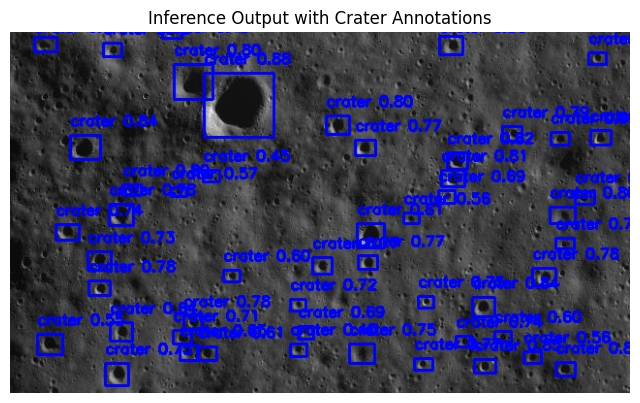

[INFO] No path of >= 100m found from the start. Try adjusting parameters.
No valid path found for crator_images/55_jpg.rf.1ec003195178ff3116f1f0666c9eca72.jpg. Skipping.
[INFO] No path of >= 100m found from the start. Try adjusting parameters.
No valid path found for crator_images/56_jpg.rf.0543da623b2795c354013d5b7ad87a3c.jpg. Skipping.
[INFO] No path of >= 100m found from the start. Try adjusting parameters.
No valid path found for crator_images/6_jpg.rf.8eca318e6b54b89554e207fe81b12993.jpg. Skipping.
[INFO] No path of >= 100m found from the start. Try adjusting parameters.
No valid path found for crator_images/77_jpg.rf.b404c9816bdcce005857be768ef35487.jpg. Skipping.
[INFO] No path of >= 100m found from the start. Try adjusting parameters.
No valid path found for crator_images/79_jpg.rf.9e029d0db7548a8f521b265a0ea2c790.jpg. Skipping.
[INFO] No path of >= 100m found from the start. Try adjusting parameters.
No valid path found for crator_images/99_jpg.rf.5cb7ff8f76168db96b7ca7f54cfe3

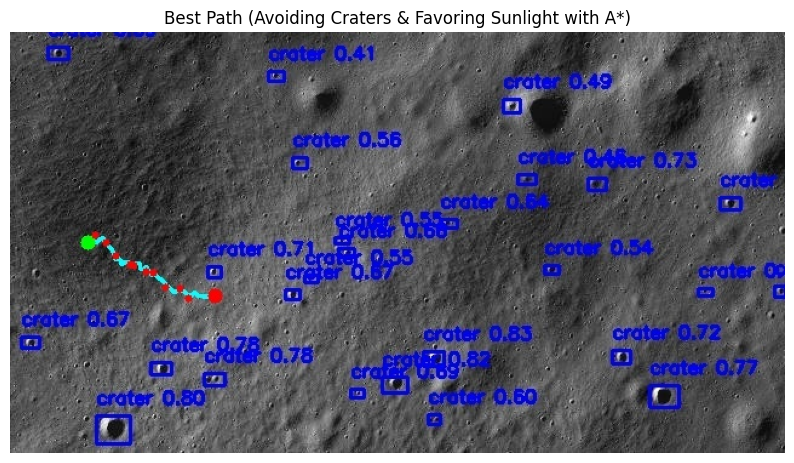

In [7]:
def process_all_paths_avoiding_craters_a_star(df_results,
                                              all_paths_folder="all_paths_avoiding_craters",
                                              best_path_folder="best_path"):
    """
    For each image in df_results, plan a path >= 100m using A* that avoids crater bounding boxes
    while favoring areas with high sunlight. Saves annotated images and selects the best one based
    on crater coverage (lowest safety_score).
    """
    os.makedirs(all_paths_folder, exist_ok=True)
    os.makedirs(best_path_folder, exist_ok=True)
    records = []

    for idx, row in df_results.iterrows():
        image_path = row['image_path']
        preds = row['inference_result'].get("predictions", [])
        safety_score = sum(p["width"] * p["height"] for p in preds)

        annotated_img, path_coords, stops = plan_rover_path_avoid_craters_a_star(
            image_path=image_path,
            predictions=preds,
            path_length_m=100,
            num_stops=10,
            real_width_m=600,
            real_height_m=150
        )

        if annotated_img is None:
            print(f"No valid path found for {image_path}. Skipping.")
            continue

        base_name = os.path.basename(image_path)
        out_name = os.path.splitext(base_name)[0] + "_avoid_a_star.jpg"
        out_path = os.path.join(all_paths_folder, out_name)
        annotated_bgr = cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(out_path, annotated_bgr)

        record = {
            "image_path": image_path,
            "annotated_image_path": out_path,
            "safety_score": safety_score,
            "path_length_pixels": len(path_coords),
            "landing_spot": path_coords[0] if path_coords else None,
            "end_spot": path_coords[-1] if path_coords else None,
            "stops": stops
        }
        records.append(record)

    paths_df = pd.DataFrame(records)
    if len(paths_df) == 0:
        print("[INFO] No paths found for any image!")
        return None, None, None

    best_idx = paths_df["safety_score"].idxmin()
    best_record = paths_df.loc[best_idx]
    best_annotated_img = cv2.imread(best_record["annotated_image_path"])
    best_output_path = os.path.join(best_path_folder, "best_path.jpg")
    cv2.imwrite(best_output_path, best_annotated_img)

    return paths_df, best_record, best_output_path
# Remember to take out the train and valid files from the Chandrayaan-2-OHRC-Lunar-Crater-Dataset-4 folder or just add that in the path
train_dir = "/content/train/images"
valid_dir = "/content/valid/images"

df_results = process_images(train_dir, valid_dir)
print(df_results.head())

sample_image_path = df_results.iloc[0]['image_path']
sample_img = cv2.imread(sample_image_path)
sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(sample_img_rgb)
plt.axis('off')
plt.title("Inference Output with Crater Annotations")
plt.show()

paths_df, best_record, best_output_path = process_all_paths_avoiding_craters_a_star(df_results)
if paths_df is not None:
    print("All path details:\n", paths_df)
    print("\nBest path details:\n", best_record)
    best_img_rgb = cv2.cvtColor(cv2.imread(best_output_path), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(best_img_rgb)
    plt.title("Best Path (Avoiding Craters & Favoring Sunlight with A*)")
    plt.axis('off')
    plt.show()